# Ноутбук 1: EMNIST - подготовка данных и базовый классификатор/эмбеддинги

**Цель:** Настроить масштабируемый пайплайн, получить сильный супервизорный бейзлайн и общий "каркас" оценок для следующих ноутбуков.

**Что делаем:**
1. Загрузка EMNIST датасета
2. Пре-процессинг без утечек данных
3. Базовая MLP модель с классификационной головой
4. Обучение с ранней остановкой
5. Извлечение и оценка эмбеддингов
6. Инфраструктура для будущих ноутбуков


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: NVIDIA L40
GPU memory: 44.38 GB


## 1. Загрузка и проверка данных EMNIST

Загружаем датасет EMNIST (Extended MNIST) - расширенная версия MNIST с буквами и цифрами. Используем EMNIST/ByClass с 62 классами (10 цифр + 26 заглавных + 26 строчных букв). Изображения размером 28x28 пикселей, флаттеним в векторы размерности 784. Проверяем качество данных: наличие NaN и бесконечных значений, типы данных, распределение классов.


In [2]:
print("Загрузка датасета EMNIST...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset_full = datasets.EMNIST(
    root='./data',
    split='byclass',
    train=True,
    download=True,
    transform=transform
)

test_dataset_full = datasets.EMNIST(
    root='./data',
    split='byclass',
    train=False,
    download=True,
    transform=transform
)

print("Преобразование в numpy массивы...")
X_train_full = []
y_train_full = []
for i in tqdm(range(len(train_dataset_full)), desc="Train"):
    img, label = train_dataset_full[i]
    X_train_full.append(img.numpy())
    y_train_full.append(label)

X_test_full = []
y_test_full = []
for i in tqdm(range(len(test_dataset_full)), desc="Test"):
    img, label = test_dataset_full[i]
    X_test_full.append(img.numpy())
    y_test_full.append(label)

X_train_full = np.array(X_train_full, dtype=np.float32)
y_train_full = np.array(y_train_full, dtype=np.int64)
X_test_full = np.array(X_test_full, dtype=np.float32)
y_test_full = np.array(y_test_full, dtype=np.int64)

print(f"\nЗагружено:")
print(f"  Train: {len(X_train_full):,} примеров")
print(f"  Test: {len(X_test_full):,} примеров")
print(f"  Фичи: {X_train_full.shape[1]}")
print(f"  Классов: {len(np.unique(y_train_full))}")

print(f"\nПроверка данных:")
print(f"  NaN в X_train: {np.isnan(X_train_full).sum()}")
print(f"  Inf в X_train: {np.isinf(X_train_full).sum()}")
print(f"  NaN в y_train: {np.isnan(y_train_full).sum()}")

unique_classes = np.unique(y_train_full)
print(f"\nКлассы: от {unique_classes.min()} до {unique_classes.max()}")
print(f"Всего уникальных классов: {len(unique_classes)}")

X = np.vstack([X_train_full, X_test_full])
y = np.hstack([y_train_full, y_test_full])


Загрузка датасета EMNIST...
Преобразование в numpy массивы...


Test: 100%|██████████| 116323/116323 [00:09<00:00, 12401.87it/s]



Загружено:
  Train: 697,932 примеров
  Test: 116,323 примеров
  Фичи: 784
  Классов: 62

Проверка данных:
  NaN в X_train: 0
  Inf в X_train: 0
  NaN в y_train: 0

Классы: от 0 до 61
Всего уникальных классов: 62


## 2. Стратифицированные сплиты train/val/test

EMNIST уже имеет разделение на train и test. Разделяем train данные на train (90%) и val (10%) с сохранением пропорций классов. Test набор оставляем как есть. Стратификация критична для многоклассовой задачи с дисбалансом классов. Проверяем распределение классов в каждом сплите.


In [3]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

X_test = X_test_full
y_test = y_test_full

print(f"Разделение данных:")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(X_train_full)*100:.1f}% от train)")
print(f"  Val:   {len(X_val):,} ({len(X_val)/len(X_train_full)*100:.1f}% от train)")
print(f"  Test:  {len(X_test):,} (оригинальный test набор)")

def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nРаспределение классов ({name}):")
    print(f"  Уникальных классов: {len(unique)}")
    print(f"  Минимум примеров на класс: {counts.min()}")
    print(f"  Максимум примеров на класс: {counts.max()}")
    print(f"  Среднее примеров на класс: {counts.mean():.1f}")
    print(f"  Медиана примеров на класс: {np.median(counts):.1f}")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Val")
print_class_distribution(y_test, "Test")


Разделение данных:
  Train: 628,138 (90.0% от train)
  Val:   69,794 (10.0% от train)
  Test:  116,323 (оригинальный test набор)

Распределение классов (Train):
  Уникальных классов: 62
  Минимум примеров на класс: 1706
  Максимум примеров на класс: 34537
  Среднее примеров на класс: 10131.3
  Медиана примеров на класс: 4567.0

Распределение классов (Val):
  Уникальных классов: 62
  Минимум примеров на класс: 190
  Максимум примеров на класс: 3837
  Среднее примеров на класс: 1125.7
  Медиана примеров на класс: 507.5

Распределение классов (Test):
  Уникальных классов: 62
  Минимум примеров на класс: 317
  Максимум примеров на класс: 6330
  Среднее примеров на класс: 1876.2
  Медиана примеров на класс: 830.5


## 3. Пре-процессинг без утечек данных

Применяем стандартизацию признаков: обучаем StandardScaler только на train данных, затем применяем к val и test. Формула стандартизации:

$$z_i = \frac{x_i - \mu_{train}}{\sigma_{train}}$$

где $\mu_{train}$ и $\sigma_{train}$ - среднее и стандартное отклонение по train данным. Обрабатываем возможные NaN и бесконечные значения.


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Проверка после масштабирования:")
print(f"  Train - NaN: {np.isnan(X_train_scaled).sum()}, Inf: {np.isinf(X_train_scaled).sum()}")
print(f"  Val - NaN: {np.isnan(X_val_scaled).sum()}, Inf: {np.isinf(X_val_scaled).sum()}")
print(f"  Test - NaN: {np.isnan(X_test_scaled).sum()}, Inf: {np.isinf(X_test_scaled).sum()}")

X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nСтатистика после масштабирования:")
print(f"  Train - mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"  Val - mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print(f"  Test - mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")


Проверка после масштабирования:
  Train - NaN: 0, Inf: 0
  Val - NaN: 0, Inf: 0
  Test - NaN: 0, Inf: 0

Статистика после масштабирования:
  Train - mean: 0.0000, std: 0.9761
  Val - mean: -0.0005, std: 1.4475
  Test - mean: 0.0023, std: 12.9602


## 4. Анализ дисбаланса классов и веса

Анализируем распределение классов и вычисляем веса для взвешенной функции потерь. Вес класса вычисляется как:

$$w_c = \frac{N}{C \cdot n_c}$$

где $N$ - общее количество примеров, $C$ - количество классов, $n_c$ - количество примеров класса $c$. Это позволяет сбалансировать вклад редких классов в loss. Визуализируем распределение размеров классов.


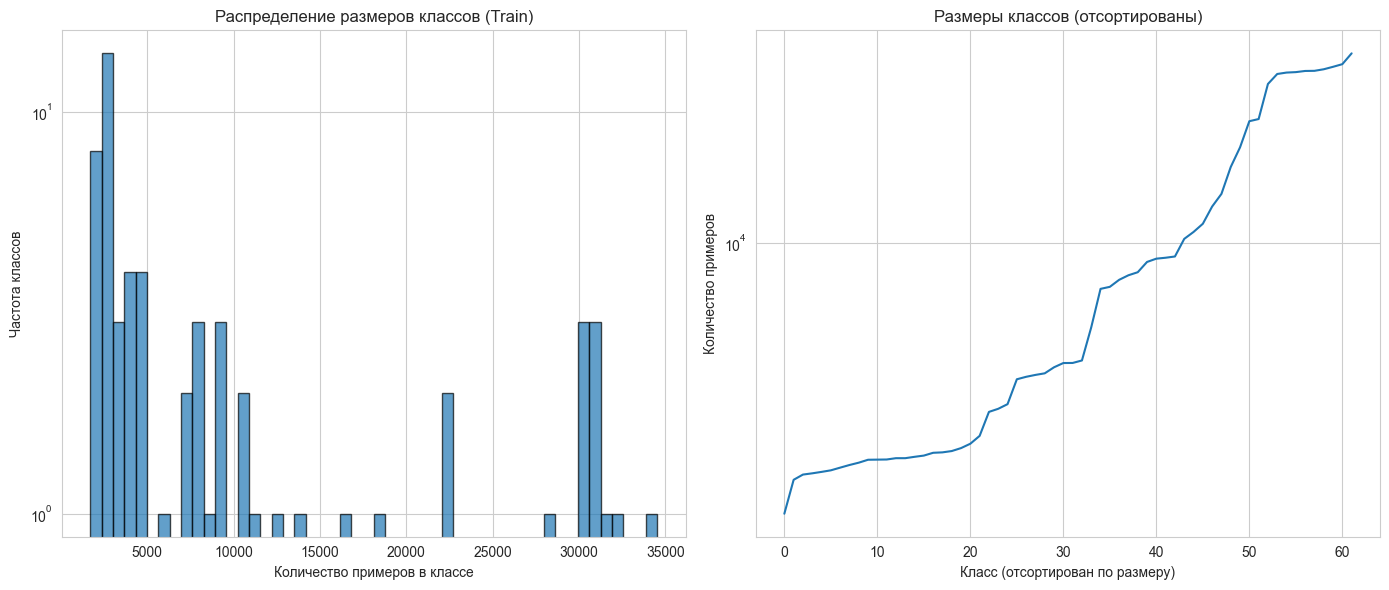


Веса классов:
  Минимальный вес: 0.2933
  Максимальный вес: 5.9386
  Средний вес: 2.3193

Создан тензор весов размером: torch.Size([62])


In [5]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_freq = counts_train / len(y_train)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(counts_train, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Количество примеров в классе')
plt.ylabel('Частота классов')
plt.title('Распределение размеров классов (Train)')
plt.yscale('log')

plt.subplot(1, 2, 2)
sorted_counts = np.sort(counts_train)
plt.plot(sorted_counts)
plt.xlabel('Класс (отсортирован по размеру)')
plt.ylabel('Количество примеров')
plt.title('Размеры классов (отсортированы)')
plt.yscale('log')
plt.tight_layout()
plt.show()

total_samples = len(y_train)
n_classes = len(unique_train)
class_weights = total_samples / (n_classes * counts_train)
class_weight_dict = {int(cls): float(weight) for cls, weight in zip(unique_train, class_weights)}

print(f"\nВеса классов:")
print(f"  Минимальный вес: {class_weights.min():.4f}")
print(f"  Максимальный вес: {class_weights.max():.4f}")
print(f"  Средний вес: {class_weights.mean():.4f}")

max_class = int(y_train.max())
weight_tensor = torch.zeros(max_class + 1, dtype=torch.float32)
for cls, weight in class_weight_dict.items():
    weight_tensor[cls] = weight

print(f"\nСоздан тензор весов размером: {weight_tensor.shape}")


## 5. Dataset и DataLoader классы

Создаем PyTorch Dataset и DataLoader с опциональным WeightedRandomSampler для балансировки батчей. WeightedRandomSampler использует вычисленные веса классов для семплирования примеров, что помогает модели лучше обучаться на редких классах.


In [6]:
class EMNISTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EMNISTDataset(X_train_scaled, y_train)
val_dataset = EMNISTDataset(X_val_scaled, y_val)
test_dataset = EMNISTDataset(X_test_scaled, y_test)

use_weighted_sampler = True

if use_weighted_sampler:
    sample_weights = np.array([class_weight_dict[int(y)] for y in y_train])
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=512,
        sampler=sampler,
        num_workers=4,
        pin_memory=True if torch.cuda.is_available() else False
    )
else:
    train_loader = DataLoader(
        train_dataset,
        batch_size=512,
        shuffle=True,
        num_workers=4,
        pin_memory=True if torch.cuda.is_available() else False
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=512,
    shuffle=False,
    num_workers=4,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"DataLoaders созданы:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


DataLoaders созданы:
  Train batches: 1227
  Val batches: 137
  Test batches: 228


## 6. MLP модель: энкодер + классификационная голова

Строим архитектуру из двух компонентов:
- **Энкодер**: MLP с несколькими скрытыми слоями, BatchNorm, Dropout, выходной слой для эмбеддингов размерности $d_{emb}$ с L2-нормировкой
- **Классификационная голова**: линейный слой, преобразующий эмбеддинги в логиты для $C$ классов

Формула энкодера: $e = \text{MLP}(x)$, затем $e \leftarrow e / \|e\|_2$ (L2-нормировка)

Формула классификатора: $\text{logits} = W \cdot e + b$, где $W \in \mathbb{R}^{C \times d_{emb}}$


In [7]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128], dropout=0.3, embedding_dim=128):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, embedding_dim))
        self.encoder = nn.Sequential(*layers)
        
    def forward(self, x, normalize=True):
        embeddings = self.encoder(x)
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings


class ClassificationHead(nn.Module):
    def __init__(self, embedding_dim, n_classes):
        super().__init__()
        self.classifier = nn.Linear(embedding_dim, n_classes)
    
    def forward(self, embeddings):
        return self.classifier(embeddings)


class MLPClassifier(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[512, 256, 128], 
                 dropout=0.3, embedding_dim=128):
        super().__init__()
        self.encoder = MLPEncoder(input_dim, hidden_dims, dropout, embedding_dim)
        self.classifier = ClassificationHead(embedding_dim, n_classes)
    
    def forward(self, x, return_embeddings=False):
        embeddings = self.encoder(x, normalize=True)
        logits = self.classifier(embeddings)
        if return_embeddings:
            return logits, embeddings
        return logits
    
    def get_embeddings(self, x):
        with torch.no_grad():
            return self.encoder(x, normalize=True)


n_classes = len(np.unique(y_train))
input_dim = X_train_scaled.shape[1]
embedding_dim = 128

model = MLPClassifier(
    input_dim=input_dim,
    n_classes=n_classes,
    hidden_dims=[512, 256, 128],
    dropout=0.3,
    embedding_dim=embedding_dim
).to(device)

print(f"Модель создана:")
print(f"  Input dim: {input_dim}")
print(f"  Embedding dim: {embedding_dim}")
print(f"  Num classes: {n_classes}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Модель создана:
  Input dim: 784
  Embedding dim: 128
  Num classes: 62
  Total parameters: 592,446
  Trainable parameters: 592,446


## 7. Функции для метрик и оценки

Реализуем метрики для оценки качества классификации и retrieval:

- **Accuracy**: доля правильных предсказаний
- **Macro F1**: среднее F1 по всем классам: $\text{F1}_{macro} = \frac{1}{C}\sum_{c=1}^{C} \text{F1}_c$
- **Recall@k**: доля примеров, где правильный класс в топ-k предсказаниях
- **MAP@k**: Mean Average Precision@k: $\text{MAP@k} = \frac{1}{N}\sum_{i=1}^{N} \frac{1}{\text{rank}_i}$ если правильный класс в топ-k, иначе 0
- **kNN оценка**: поиск ближайших соседей по косинусному расстоянию в пространстве эмбеддингов


In [8]:
def compute_metrics(y_true, y_pred, y_proba=None):
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }


def recall_at_k(y_true, y_pred_proba, k=5):
    recall_k = []
    for i in range(len(y_true)):
        top_k_indices = np.argsort(y_pred_proba[i])[-k:][::-1]
        recall_k.append(1.0 if y_true[i] in top_k_indices else 0.0)
    return np.mean(recall_k)


def map_at_k(y_true, y_pred_proba, k=5):
    ap_scores = []
    for i in range(len(y_true)):
        true_class = y_true[i]
        top_k_indices = np.argsort(y_pred_proba[i])[-k:][::-1]
        
        if true_class in top_k_indices:
            rank = np.where(top_k_indices == true_class)[0][0] + 1
            ap = 1.0 / rank
        else:
            ap = 0.0
        ap_scores.append(ap)
    return np.mean(ap_scores)


def evaluate_model(model, dataloader, device, return_embeddings=False):
    model.eval()
    all_preds = []
    all_labels = []
    all_probas = []
    all_embeddings = []
    
    with torch.no_grad():
        for X_batch, y_batch in tqdm(dataloader, desc="Evaluating"):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            if return_embeddings:
                logits, embeddings = model(X_batch, return_embeddings=True)
                all_embeddings.append(embeddings.cpu().numpy())
            else:
                logits = model(X_batch)
            
            probas = F.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            all_probas.append(probas.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probas = np.concatenate(all_probas)
    
    metrics = compute_metrics(all_labels, all_preds, all_probas)
    
    for k in [5, 10, 20]:
        metrics[f'recall@{k}'] = recall_at_k(all_labels, all_probas, k=k)
        metrics[f'map@{k}'] = map_at_k(all_labels, all_probas, k=k)
    
    result = {'metrics': metrics, 'predictions': all_preds, 'labels': all_labels, 'probas': all_probas}
    
    if return_embeddings:
        all_embeddings = np.concatenate(all_embeddings)
        result['embeddings'] = all_embeddings
    
    return result


def evaluate_embeddings_knn(train_embeddings, train_labels, val_embeddings, val_labels, k=5):
    nn = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
    nn.fit(train_embeddings)
    
    distances, indices = nn.kneighbors(val_embeddings)
    
    recall_k = []
    for i in range(len(val_labels)):
        neighbor_labels = train_labels[indices[i]]
        recall_k.append(1.0 if val_labels[i] in neighbor_labels else 0.0)
    
    recall_at_k_score = np.mean(recall_k)
    
    top_k_accuracy = recall_at_k_score
    
    return {
        'recall@k': recall_at_k_score,
        'top_k_accuracy': top_k_accuracy
    }

print("Функции для оценки созданы")


Функции для оценки созданы


## 8. Обучение модели

Обучаем модель с взвешенной Cross-Entropy loss:

$$\mathcal{L}_{CE} = -\sum_{i=1}^{N} w_{y_i} \log \frac{\exp(z_{y_i})}{\sum_{c=1}^{C} \exp(z_c)}$$

где $w_{y_i}$ - вес класса примера $i$, $z_c$ - логит для класса $c$. Используем AdamW оптимизатор с learning rate scheduling и ранней остановкой по val macro-F1 для предотвращения переобучения.


In [9]:
criterion = nn.CrossEntropyLoss(weight=weight_tensor.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_f1 = 0.0
patience = 10
patience_counter = 0
best_model_state = None

num_epochs = 50
print(f"Начинаем обучение на {num_epochs} эпох...")
print(f"Ранняя остановка: patience={patience}, метрика=val macro-F1")


Начинаем обучение на 50 эпох...
Ранняя остановка: patience=10, метрика=val macro-F1


In [10]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []
    
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_preds.append(preds.cpu().numpy())
        train_labels.append(y_batch.cpu().numpy())
    
    train_loss /= len(train_loader)
    train_preds = np.concatenate(train_preds)
    train_labels = np.concatenate(train_labels)
    train_metrics = compute_metrics(train_labels, train_preds)
    
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_preds.append(preds.cpu().numpy())
            val_labels.append(y_batch.cpu().numpy())
    
    val_loss /= len(val_loader)
    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)
    val_metrics = compute_metrics(val_labels, val_preds)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_metrics['accuracy'])
    history['train_f1'].append(train_metrics['macro_f1'])
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['macro_f1'])
    
    scheduler.step(val_metrics['macro_f1'])
    
    if val_metrics['macro_f1'] > best_val_f1:
        best_val_f1 = val_metrics['macro_f1']
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"Новый лучший результат! Val F1: {best_val_f1:.4f}")
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['macro_f1']:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['macro_f1']:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print()
    
    if patience_counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch+1}")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nЗагружена лучшая модель с Val F1: {best_val_f1:.4f}")


Epoch 1/50: 100%|██████████| 1227/1227 [00:06<00:00, 183.20it/s]


Новый лучший результат! Val F1: 0.2874
Epoch 1/50:
  Train - Loss: 1.6560, Acc: 0.4063, F1: 0.3155
  Val   - Loss: 1.3523, Acc: 0.2294, F1: 0.2874
  LR: 0.001000



Epoch 2/50: 100%|██████████| 1227/1227 [00:04<00:00, 267.51it/s]


Новый лучший результат! Val F1: 0.4256
Epoch 2/50:
  Train - Loss: 0.8115, Acc: 0.5515, F1: 0.4799
  Val   - Loss: 1.0480, Acc: 0.4039, F1: 0.4256
  LR: 0.001000



Epoch 3/50: 100%|██████████| 1227/1227 [00:04<00:00, 266.74it/s]


Новый лучший результат! Val F1: 0.4858
Epoch 3/50:
  Train - Loss: 0.6991, Acc: 0.6094, F1: 0.5582
  Val   - Loss: 0.9533, Acc: 0.4798, F1: 0.4858
  LR: 0.001000



Epoch 4/50: 100%|██████████| 1227/1227 [00:04<00:00, 251.35it/s]


Новый лучший результат! Val F1: 0.5046
Epoch 4/50:
  Train - Loss: 0.6457, Acc: 0.6365, F1: 0.5931
  Val   - Loss: 0.9018, Acc: 0.5084, F1: 0.5046
  LR: 0.001000



Epoch 5/50: 100%|██████████| 1227/1227 [00:05<00:00, 242.61it/s]


Новый лучший результат! Val F1: 0.5156
Epoch 5/50:
  Train - Loss: 0.6145, Acc: 0.6492, F1: 0.6078
  Val   - Loss: 0.8762, Acc: 0.5237, F1: 0.5156
  LR: 0.001000



Epoch 6/50: 100%|██████████| 1227/1227 [00:04<00:00, 257.22it/s]


Новый лучший результат! Val F1: 0.5239
Epoch 6/50:
  Train - Loss: 0.5933, Acc: 0.6580, F1: 0.6184
  Val   - Loss: 0.8608, Acc: 0.5321, F1: 0.5239
  LR: 0.001000



Epoch 7/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.84it/s]


Новый лучший результат! Val F1: 0.5279
Epoch 7/50:
  Train - Loss: 0.5740, Acc: 0.6662, F1: 0.6268
  Val   - Loss: 0.8593, Acc: 0.5354, F1: 0.5279
  LR: 0.001000



Epoch 8/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.93it/s]


Новый лучший результат! Val F1: 0.5319
Epoch 8/50:
  Train - Loss: 0.5578, Acc: 0.6718, F1: 0.6332
  Val   - Loss: 0.8534, Acc: 0.5432, F1: 0.5319
  LR: 0.001000



Epoch 9/50: 100%|██████████| 1227/1227 [00:04<00:00, 266.20it/s]


Новый лучший результат! Val F1: 0.5346
Epoch 9/50:
  Train - Loss: 0.5468, Acc: 0.6759, F1: 0.6382
  Val   - Loss: 0.8430, Acc: 0.5465, F1: 0.5346
  LR: 0.001000



Epoch 10/50: 100%|██████████| 1227/1227 [00:04<00:00, 263.22it/s]


Новый лучший результат! Val F1: 0.5407
Epoch 10/50:
  Train - Loss: 0.5328, Acc: 0.6809, F1: 0.6436
  Val   - Loss: 0.8295, Acc: 0.5506, F1: 0.5407
  LR: 0.001000



Epoch 11/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.43it/s]


Новый лучший результат! Val F1: 0.5429
Epoch 11/50:
  Train - Loss: 0.5263, Acc: 0.6828, F1: 0.6461
  Val   - Loss: 0.8394, Acc: 0.5528, F1: 0.5429
  LR: 0.001000



Epoch 12/50: 100%|██████████| 1227/1227 [00:04<00:00, 265.57it/s]


Новый лучший результат! Val F1: 0.5445
Epoch 12/50:
  Train - Loss: 0.5176, Acc: 0.6871, F1: 0.6503
  Val   - Loss: 0.8316, Acc: 0.5521, F1: 0.5445
  LR: 0.001000



Epoch 13/50: 100%|██████████| 1227/1227 [00:04<00:00, 255.98it/s]


Новый лучший результат! Val F1: 0.5479
Epoch 13/50:
  Train - Loss: 0.5107, Acc: 0.6886, F1: 0.6526
  Val   - Loss: 0.8176, Acc: 0.5623, F1: 0.5479
  LR: 0.001000



Epoch 14/50: 100%|██████████| 1227/1227 [00:04<00:00, 253.97it/s]


Epoch 14/50:
  Train - Loss: 0.5016, Acc: 0.6926, F1: 0.6562
  Val   - Loss: 0.8327, Acc: 0.5587, F1: 0.5471
  LR: 0.001000



Epoch 15/50: 100%|██████████| 1227/1227 [00:04<00:00, 274.34it/s]


Новый лучший результат! Val F1: 0.5500
Epoch 15/50:
  Train - Loss: 0.4974, Acc: 0.6946, F1: 0.6582
  Val   - Loss: 0.8247, Acc: 0.5610, F1: 0.5500
  LR: 0.001000



Epoch 16/50: 100%|██████████| 1227/1227 [00:04<00:00, 253.67it/s]


Новый лучший результат! Val F1: 0.5504
Epoch 16/50:
  Train - Loss: 0.4906, Acc: 0.6972, F1: 0.6613
  Val   - Loss: 0.8279, Acc: 0.5637, F1: 0.5504
  LR: 0.001000



Epoch 17/50: 100%|██████████| 1227/1227 [00:04<00:00, 248.56it/s]


Новый лучший результат! Val F1: 0.5513
Epoch 17/50:
  Train - Loss: 0.4837, Acc: 0.6987, F1: 0.6630
  Val   - Loss: 0.8270, Acc: 0.5663, F1: 0.5513
  LR: 0.001000



Epoch 18/50: 100%|██████████| 1227/1227 [00:04<00:00, 253.24it/s]


Epoch 18/50:
  Train - Loss: 0.4781, Acc: 0.7005, F1: 0.6654
  Val   - Loss: 0.8401, Acc: 0.5602, F1: 0.5490
  LR: 0.001000



Epoch 19/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.34it/s]


Новый лучший результат! Val F1: 0.5534
Epoch 19/50:
  Train - Loss: 0.4715, Acc: 0.7032, F1: 0.6671
  Val   - Loss: 0.8302, Acc: 0.5651, F1: 0.5534
  LR: 0.001000



Epoch 20/50: 100%|██████████| 1227/1227 [00:04<00:00, 263.75it/s]


Новый лучший результат! Val F1: 0.5572
Epoch 20/50:
  Train - Loss: 0.4674, Acc: 0.7042, F1: 0.6693
  Val   - Loss: 0.8263, Acc: 0.5690, F1: 0.5572
  LR: 0.001000



Epoch 21/50: 100%|██████████| 1227/1227 [00:04<00:00, 261.35it/s]


Epoch 21/50:
  Train - Loss: 0.4656, Acc: 0.7054, F1: 0.6699
  Val   - Loss: 0.8282, Acc: 0.5638, F1: 0.5528
  LR: 0.001000



Epoch 22/50: 100%|██████████| 1227/1227 [00:04<00:00, 255.69it/s]


Новый лучший результат! Val F1: 0.5584
Epoch 22/50:
  Train - Loss: 0.4600, Acc: 0.7073, F1: 0.6717
  Val   - Loss: 0.8232, Acc: 0.5689, F1: 0.5584
  LR: 0.001000



Epoch 23/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.87it/s]


Новый лучший результат! Val F1: 0.5591
Epoch 23/50:
  Train - Loss: 0.4555, Acc: 0.7091, F1: 0.6737
  Val   - Loss: 0.8248, Acc: 0.5728, F1: 0.5591
  LR: 0.001000



Epoch 24/50: 100%|██████████| 1227/1227 [00:04<00:00, 255.80it/s]


Новый лучший результат! Val F1: 0.5591
Epoch 24/50:
  Train - Loss: 0.4514, Acc: 0.7108, F1: 0.6756
  Val   - Loss: 0.8245, Acc: 0.5726, F1: 0.5591
  LR: 0.001000



Epoch 25/50: 100%|██████████| 1227/1227 [00:04<00:00, 260.22it/s]


Новый лучший результат! Val F1: 0.5624
Epoch 25/50:
  Train - Loss: 0.4497, Acc: 0.7110, F1: 0.6763
  Val   - Loss: 0.8197, Acc: 0.5772, F1: 0.5624
  LR: 0.001000



Epoch 26/50: 100%|██████████| 1227/1227 [00:04<00:00, 256.03it/s]


Epoch 26/50:
  Train - Loss: 0.4452, Acc: 0.7120, F1: 0.6770
  Val   - Loss: 0.8270, Acc: 0.5736, F1: 0.5596
  LR: 0.001000



Epoch 27/50: 100%|██████████| 1227/1227 [00:04<00:00, 252.02it/s]


Epoch 27/50:
  Train - Loss: 0.4427, Acc: 0.7127, F1: 0.6775
  Val   - Loss: 0.8277, Acc: 0.5747, F1: 0.5585
  LR: 0.001000



Epoch 28/50: 100%|██████████| 1227/1227 [00:04<00:00, 245.53it/s]


Epoch 28/50:
  Train - Loss: 0.4366, Acc: 0.7157, F1: 0.6807
  Val   - Loss: 0.8320, Acc: 0.5720, F1: 0.5593
  LR: 0.001000



Epoch 29/50: 100%|██████████| 1227/1227 [00:04<00:00, 249.99it/s]


Epoch 29/50:
  Train - Loss: 0.4333, Acc: 0.7161, F1: 0.6811
  Val   - Loss: 0.8251, Acc: 0.5743, F1: 0.5600
  LR: 0.001000



Epoch 30/50: 100%|██████████| 1227/1227 [00:04<00:00, 259.92it/s]


Epoch 30/50:
  Train - Loss: 0.4323, Acc: 0.7171, F1: 0.6823
  Val   - Loss: 0.8422, Acc: 0.5724, F1: 0.5608
  LR: 0.001000



Epoch 31/50: 100%|██████████| 1227/1227 [00:04<00:00, 274.34it/s]


Новый лучший результат! Val F1: 0.5633
Epoch 31/50:
  Train - Loss: 0.4277, Acc: 0.7185, F1: 0.6836
  Val   - Loss: 0.8309, Acc: 0.5765, F1: 0.5633
  LR: 0.001000



Epoch 32/50: 100%|██████████| 1227/1227 [00:04<00:00, 274.43it/s]


Новый лучший результат! Val F1: 0.5637
Epoch 32/50:
  Train - Loss: 0.4275, Acc: 0.7185, F1: 0.6845
  Val   - Loss: 0.8282, Acc: 0.5780, F1: 0.5637
  LR: 0.001000



Epoch 33/50: 100%|██████████| 1227/1227 [00:04<00:00, 263.93it/s]


Epoch 33/50:
  Train - Loss: 0.4232, Acc: 0.7212, F1: 0.6863
  Val   - Loss: 0.8359, Acc: 0.5781, F1: 0.5628
  LR: 0.001000



Epoch 34/50: 100%|██████████| 1227/1227 [00:04<00:00, 269.68it/s]


Новый лучший результат! Val F1: 0.5666
Epoch 34/50:
  Train - Loss: 0.4212, Acc: 0.7209, F1: 0.6862
  Val   - Loss: 0.8310, Acc: 0.5830, F1: 0.5666
  LR: 0.001000



Epoch 35/50: 100%|██████████| 1227/1227 [00:04<00:00, 265.78it/s]


Epoch 35/50:
  Train - Loss: 0.4192, Acc: 0.7220, F1: 0.6878
  Val   - Loss: 0.8339, Acc: 0.5814, F1: 0.5653
  LR: 0.001000



Epoch 36/50: 100%|██████████| 1227/1227 [00:04<00:00, 276.02it/s]


Epoch 36/50:
  Train - Loss: 0.4160, Acc: 0.7235, F1: 0.6894
  Val   - Loss: 0.8363, Acc: 0.5795, F1: 0.5648
  LR: 0.001000



Epoch 37/50: 100%|██████████| 1227/1227 [00:04<00:00, 289.80it/s]


Epoch 37/50:
  Train - Loss: 0.4133, Acc: 0.7248, F1: 0.6907
  Val   - Loss: 0.8375, Acc: 0.5814, F1: 0.5666
  LR: 0.001000



Epoch 38/50: 100%|██████████| 1227/1227 [00:04<00:00, 287.42it/s]


Новый лучший результат! Val F1: 0.5666
Epoch 38/50:
  Train - Loss: 0.4113, Acc: 0.7252, F1: 0.6915
  Val   - Loss: 0.8456, Acc: 0.5816, F1: 0.5666
  LR: 0.001000



Epoch 39/50: 100%|██████████| 1227/1227 [00:04<00:00, 291.99it/s]


Epoch 39/50:
  Train - Loss: 0.4071, Acc: 0.7266, F1: 0.6931
  Val   - Loss: 0.8443, Acc: 0.5838, F1: 0.5663
  LR: 0.001000



Epoch 40/50: 100%|██████████| 1227/1227 [00:04<00:00, 292.66it/s]


Epoch 40/50:
  Train - Loss: 0.4087, Acc: 0.7254, F1: 0.6914
  Val   - Loss: 0.8464, Acc: 0.5808, F1: 0.5642
  LR: 0.000500



Epoch 41/50: 100%|██████████| 1227/1227 [00:04<00:00, 270.74it/s]


Новый лучший результат! Val F1: 0.5696
Epoch 41/50:
  Train - Loss: 0.3933, Acc: 0.7307, F1: 0.6975
  Val   - Loss: 0.8464, Acc: 0.5841, F1: 0.5696
  LR: 0.000500



Epoch 42/50: 100%|██████████| 1227/1227 [00:04<00:00, 272.03it/s]


Новый лучший результат! Val F1: 0.5703
Epoch 42/50:
  Train - Loss: 0.3851, Acc: 0.7341, F1: 0.7006
  Val   - Loss: 0.8446, Acc: 0.5855, F1: 0.5703
  LR: 0.000500



Epoch 43/50: 100%|██████████| 1227/1227 [00:04<00:00, 277.70it/s]


Epoch 43/50:
  Train - Loss: 0.3813, Acc: 0.7347, F1: 0.7011
  Val   - Loss: 0.8543, Acc: 0.5856, F1: 0.5696
  LR: 0.000500



Epoch 44/50: 100%|██████████| 1227/1227 [00:04<00:00, 289.95it/s]


Новый лучший результат! Val F1: 0.5703
Epoch 44/50:
  Train - Loss: 0.3793, Acc: 0.7360, F1: 0.7025
  Val   - Loss: 0.8513, Acc: 0.5868, F1: 0.5703
  LR: 0.000500



Epoch 45/50: 100%|██████████| 1227/1227 [00:04<00:00, 270.16it/s]


Epoch 45/50:
  Train - Loss: 0.3778, Acc: 0.7365, F1: 0.7033
  Val   - Loss: 0.8571, Acc: 0.5844, F1: 0.5691
  LR: 0.000500



Epoch 46/50: 100%|██████████| 1227/1227 [00:04<00:00, 269.54it/s]


Epoch 46/50:
  Train - Loss: 0.3744, Acc: 0.7381, F1: 0.7047
  Val   - Loss: 0.8594, Acc: 0.5867, F1: 0.5689
  LR: 0.000500



Epoch 47/50: 100%|██████████| 1227/1227 [00:04<00:00, 276.13it/s]


Новый лучший результат! Val F1: 0.5722
Epoch 47/50:
  Train - Loss: 0.3725, Acc: 0.7384, F1: 0.7054
  Val   - Loss: 0.8484, Acc: 0.5900, F1: 0.5722
  LR: 0.000500



Epoch 48/50: 100%|██████████| 1227/1227 [00:04<00:00, 265.52it/s]


Epoch 48/50:
  Train - Loss: 0.3718, Acc: 0.7392, F1: 0.7058
  Val   - Loss: 0.8534, Acc: 0.5899, F1: 0.5715
  LR: 0.000500



Epoch 49/50: 100%|██████████| 1227/1227 [00:04<00:00, 269.54it/s]


Epoch 49/50:
  Train - Loss: 0.3714, Acc: 0.7395, F1: 0.7061
  Val   - Loss: 0.8582, Acc: 0.5866, F1: 0.5692
  LR: 0.000500



Epoch 50/50: 100%|██████████| 1227/1227 [00:04<00:00, 254.10it/s]


Новый лучший результат! Val F1: 0.5728
Epoch 50/50:
  Train - Loss: 0.3665, Acc: 0.7410, F1: 0.7074
  Val   - Loss: 0.8656, Acc: 0.5882, F1: 0.5728
  LR: 0.000500


Загружена лучшая модель с Val F1: 0.5728


## 9. Визуализация истории обучения

Визуализируем динамику обучения: loss, accuracy и macro-F1 на train и validation наборах для анализа процесса обучения и выявления переобучения.


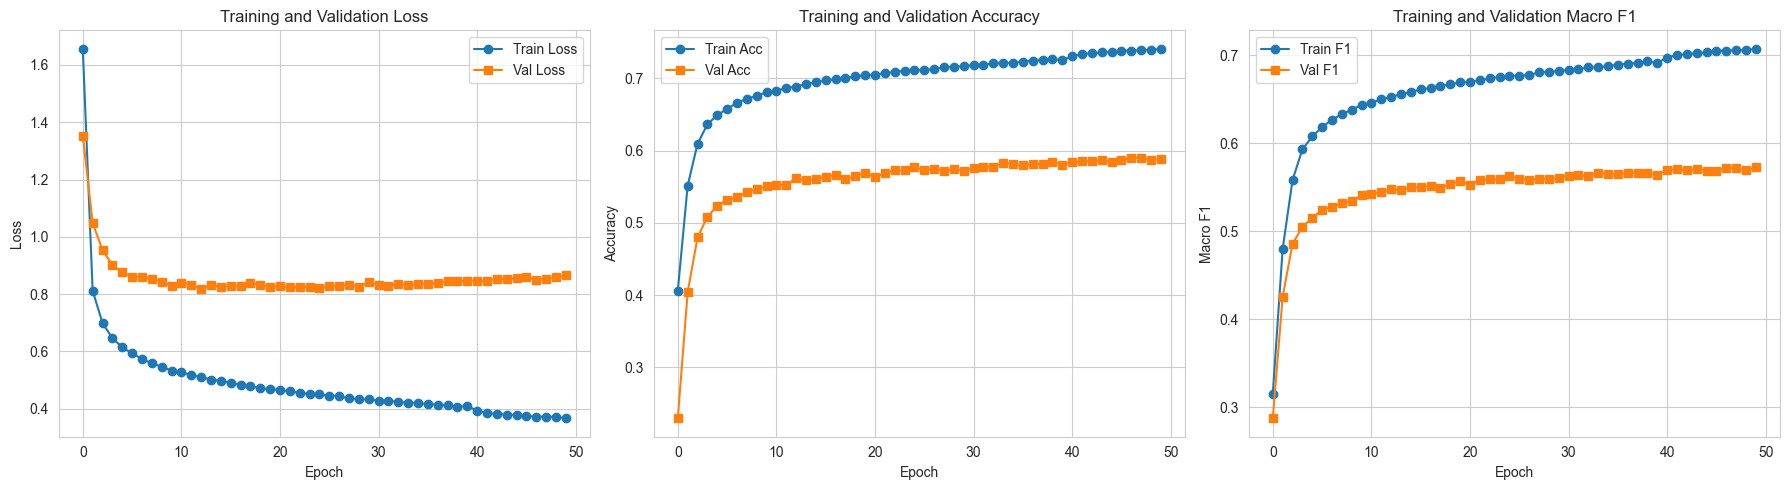

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['train_f1'], label='Train F1', marker='o')
axes[2].plot(history['val_f1'], label='Val F1', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1')
axes[2].set_title('Training and Validation Macro F1')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## 10. Оценка на тестовом наборе (softmax голова)

Оцениваем качество классификации на тестовом наборе через softmax голову модели. Вычисляем accuracy, macro-F1, micro-F1, Recall@k и MAP@k для различных значений k.


In [12]:
print("Оценка на тестовом наборе (softmax классификатор)...")
test_results = evaluate_model(model, test_loader, device, return_embeddings=False)

print("\nРезультаты на Test:")
print(f"  Accuracy: {test_results['metrics']['accuracy']:.4f}")
print(f"  Macro F1: {test_results['metrics']['macro_f1']:.4f}")
print(f"  Micro F1: {test_results['metrics']['micro_f1']:.4f}")
print(f"  Recall@5: {test_results['metrics']['recall@5']:.4f}")
print(f"  Recall@10: {test_results['metrics']['recall@10']:.4f}")
print(f"  Recall@20: {test_results['metrics']['recall@20']:.4f}")
print(f"  MAP@5: {test_results['metrics']['map@5']:.4f}")
print(f"  MAP@10: {test_results['metrics']['map@10']:.4f}")
print(f"  MAP@20: {test_results['metrics']['map@20']:.4f}")


Оценка на тестовом наборе (softmax классификатор)...


Evaluating: 100%|██████████| 228/228 [00:00<00:00, 301.85it/s]



Результаты на Test:
  Accuracy: 0.5882
  Macro F1: 0.5708
  Micro F1: 0.5882
  Recall@5: 0.9882
  Recall@10: 0.9953
  Recall@20: 0.9983
  MAP@5: 0.7592
  MAP@10: 0.7602
  MAP@20: 0.7604


## 11. Извлечение эмбеддингов и оценка через kNN

Извлекаем L2-нормированные эмбеддинги из предпоследнего слоя модели для всех наборов данных. Оцениваем качество эмбеддингов через kNN поиск по косинусному расстоянию:

$$d_{cos}(e_i, e_j) = 1 - \frac{e_i \cdot e_j}{\|e_i\| \|e_j\|} = 1 - e_i \cdot e_j$$

(для L2-нормированных векторов косинусное расстояние эквивалентно евклидову). Сравниваем результаты kNN с прямой softmax классификацией.


In [13]:
print("Извлечение эмбеддингов из предпоследнего слоя...")

train_results = evaluate_model(model, train_loader, device, return_embeddings=True)
val_results = evaluate_model(model, val_loader, device, return_embeddings=True)
test_results_emb = evaluate_model(model, test_loader, device, return_embeddings=True)

train_embeddings = train_results['embeddings']
val_embeddings = val_results['embeddings']
test_embeddings = test_results_emb['embeddings']

train_labels_emb = train_results['labels']
val_labels_emb = val_results['labels']
test_labels_emb = test_results_emb['labels']

print(f"Эмбеддинги извлечены:")
print(f"  Train: {train_embeddings.shape}")
print(f"  Val: {val_embeddings.shape}")
print(f"  Test: {test_embeddings.shape}")

train_norms = np.linalg.norm(train_embeddings, axis=1)
print(f"\nПроверка L2-нормировки:")
print(f"  Train - mean norm: {train_norms.mean():.6f}, std: {train_norms.std():.6f}")
print(f"  Ожидается: mean ≈ 1.0, std ≈ 0.0")

sample_size_train = 0.1
sample_size_val = 0.2
sample_size_test = 0.2

np.random.seed(42)
train_indices = np.random.choice(len(train_embeddings), size=int(len(train_embeddings) * sample_size_train), replace=False)
val_indices = np.random.choice(len(val_embeddings), size=int(len(val_embeddings) * sample_size_val), replace=False)
test_indices = np.random.choice(len(test_embeddings), size=int(len(test_embeddings) * sample_size_test), replace=False)

train_embeddings_sample = train_embeddings[train_indices]
val_embeddings_sample = val_embeddings[val_indices]
test_embeddings_sample = test_embeddings[test_indices]

train_labels_sample = train_labels_emb[train_indices]
val_labels_sample = val_labels_emb[val_indices]
test_labels_sample = test_labels_emb[test_indices]

print(f"\nСемплирование для ускорения оценки:")
print(f"  Train: {len(train_embeddings_sample):,} ({sample_size_train*100:.0f}%)")
print(f"  Val: {len(val_embeddings_sample):,} ({sample_size_val*100:.0f}%)")
print(f"  Test: {len(test_embeddings_sample):,} ({sample_size_test*100:.0f}%)")


Извлечение эмбеддингов из предпоследнего слоя...


Evaluating: 100%|██████████| 228/228 [00:00<00:00, 254.58it/s]


Эмбеддинги извлечены:
  Train: (628138, 128)
  Val: (69794, 128)
  Test: (116323, 128)

Проверка L2-нормировки:
  Train - mean norm: 1.000000, std: 0.000000
  Ожидается: mean ≈ 1.0, std ≈ 0.0

Семплирование для ускорения оценки:
  Train: 62,813 (10%)
  Val: 13,958 (20%)
  Test: 23,264 (20%)


In [14]:
print("\nОценка эмбеддингов через kNN (косинусное расстояние)...")
print("Используем семплированные данные для ускорения оценки")

for k in [5, 10, 20]:
    val_knn = evaluate_embeddings_knn(
        train_embeddings_sample, train_labels_sample,
        val_embeddings_sample, val_labels_sample,
        k=k
    )
    test_knn = evaluate_embeddings_knn(
        train_embeddings_sample, train_labels_sample,
        test_embeddings_sample, test_labels_sample,
        k=k
    )
    
    print(f"\nk={k}:")
    print(f"  Val Recall@{k}: {val_knn['recall@k']:.4f}")
    print(f"  Test Recall@{k}: {test_knn['recall@k']:.4f}")

print("\n" + "="*60)
print("СРАВНЕНИЕ: Softmax голова vs kNN на эмбеддингах")
print("="*60)
print("\nTest set:")
print(f"  Softmax Accuracy: {test_results['metrics']['accuracy']:.4f}")
print(f"  Softmax Recall@5: {test_results['metrics']['recall@5']:.4f}")
print(f"  Softmax Recall@10: {test_results['metrics']['recall@10']:.4f}")
print(f"  Softmax Recall@20: {test_results['metrics']['recall@20']:.4f}")

test_knn_5 = evaluate_embeddings_knn(
    train_embeddings_sample, train_labels_sample,
    test_embeddings_sample, test_labels_sample,
    k=5
)
test_knn_10 = evaluate_embeddings_knn(
    train_embeddings_sample, train_labels_sample,
    test_embeddings_sample, test_labels_sample,
    k=10
)
test_knn_20 = evaluate_embeddings_knn(
    train_embeddings_sample, train_labels_sample,
    test_embeddings_sample, test_labels_sample,
    k=20
)

print(f"\n  kNN Recall@5: {test_knn_5['recall@k']:.4f}")
print(f"  kNN Recall@10: {test_knn_10['recall@k']:.4f}")
print(f"  kNN Recall@20: {test_knn_20['recall@k']:.4f}")



Оценка эмбеддингов через kNN (косинусное расстояние)...
Используем семплированные данные для ускорения оценки

k=5:
  Val Recall@5: 0.9064
  Test Recall@5: 0.9105

k=10:
  Val Recall@10: 0.9464
  Test Recall@10: 0.9481

k=20:
  Val Recall@20: 0.9652
  Test Recall@20: 0.9651

СРАВНЕНИЕ: Softmax голова vs kNN на эмбеддингах

Test set:
  Softmax Accuracy: 0.5882
  Softmax Recall@5: 0.9882
  Softmax Recall@10: 0.9953
  Softmax Recall@20: 0.9983

  kNN Recall@5: 0.9105
  kNN Recall@10: 0.9481
  kNN Recall@20: 0.9651


## 12. Сохранение результатов и инфраструктура для будущих ноутбуков

Сохраняем обученную модель, эмбеддинги, метрики и предобработанные данные для использования в следующих ноутбуках.


In [15]:
save_dir = Path("./checkpoints/baseline")
save_dir.mkdir(parents=True, exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'n_classes': n_classes,
        'embedding_dim': embedding_dim,
        'hidden_dims': [512, 256, 128],
        'dropout': 0.3
    },
    'scaler': scaler,
    'class_weights': class_weight_dict,
    'best_val_f1': best_val_f1,
    'history': history
}, save_dir / "best_model.pt")

print(f"Модель сохранена в {save_dir / 'best_model.pt'}")

np.save(save_dir / "train_embeddings.npy", train_embeddings)
np.save(save_dir / "val_embeddings.npy", val_embeddings)
np.save(save_dir / "test_embeddings.npy", test_embeddings)
np.save(save_dir / "train_labels.npy", train_labels_emb)
np.save(save_dir / "val_labels.npy", val_labels_emb)
np.save(save_dir / "test_labels.npy", test_labels_emb)

print(f"Эмбеддинги сохранены в {save_dir}")

metrics_summary = {
    'test_softmax': test_results['metrics'],
    'test_knn': {
        'recall@5': test_knn_5['recall@k'],
        'recall@10': test_knn_10['recall@k'],
        'recall@20': test_knn_20['recall@k']
    },
    'best_val_f1': best_val_f1,
    'n_classes': n_classes,
    'embedding_dim': embedding_dim
}

with open(save_dir / "metrics_summary.pkl", "wb") as f:
    pickle.dump(metrics_summary, f)

print(f"Метрики сохранены в {save_dir / 'metrics_summary.pkl'}")

data_dir = save_dir / "data"
data_dir.mkdir(exist_ok=True)

np.save(data_dir / "X_train_scaled.npy", X_train_scaled)
np.save(data_dir / "X_val_scaled.npy", X_val_scaled)
np.save(data_dir / "X_test_scaled.npy", X_test_scaled)
np.save(data_dir / "y_train.npy", y_train)
np.save(data_dir / "y_val.npy", y_val)
np.save(data_dir / "y_test.npy", y_test)

with open(data_dir / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print(f"Данные сохранены в {data_dir}")


Модель сохранена в checkpoints/baseline/best_model.pt
Эмбеддинги сохранены в checkpoints/baseline
Метрики сохранены в checkpoints/baseline/metrics_summary.pkl
Данные сохранены в checkpoints/baseline/data
